In [31]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
dataframes = [pd.read_csv(f"data/fitness/{d}") for d in os.listdir("data/fitness/")]
df = pd.concat(dataframes, ignore_index=True)
df.rename(lambda x: x.replace("training.", ""), axis="columns", inplace=True)
df = df[[c for c in df.columns if not c.startswith("Unnamed")]]
df["evolver"] = df["solver"] + "_" + df["ea"]
df.head()

,_timestamp,top_k_fit.top_2_fit,fitness_std,fitness_median,top_k_fit.top_0_fit,top_k_fit.top_1_fit,fitness_mean,evaluation_time,_step,_runtime,run_id,generation,fitness_1q,fitness_3q,solver,ea,environment,seed,evolver
0,1.686358e+09,585.928833,436.928680,307.256897,836.009888,593.317017,238.086502,20.466824,0,22.918625,0,0,556.361877,16.815582,cgp,1+lambda,ant,0,cgp_1+lambda
1,1.686358e+09,824.758972,346.329773,732.269226,949.752197,933.162109,655.597656,20.466824,1,23.224415,1,0,820.722717,698.522888,cgp,1+lambda,ant,1,cgp_1+lambda
2,1.686358e+09,714.311462,269.376923,382.515259,981.056885,849.287476,486.170166,20.466824,2,23.524727,2,0,677.012085,295.583557,cgp,1+lambda,ant,2,cgp_1+lambda
3,1.686358e+09,763.903320,303.274658,433.953125,925.560181,811.555847,473.822845,20.466824,3,23.825352,3,0,748.293579,257.749298,cgp,1+lambda,ant,3,cgp_1+lambda
4,1.686358e+09,586.392761,356.488464,463.556854,879.398438,595.752136,380.256897,20.466824,4,24.123979,4,0,574.221680,312.126892,cgp,1+lambda,ant,4,cgp_1+lambda


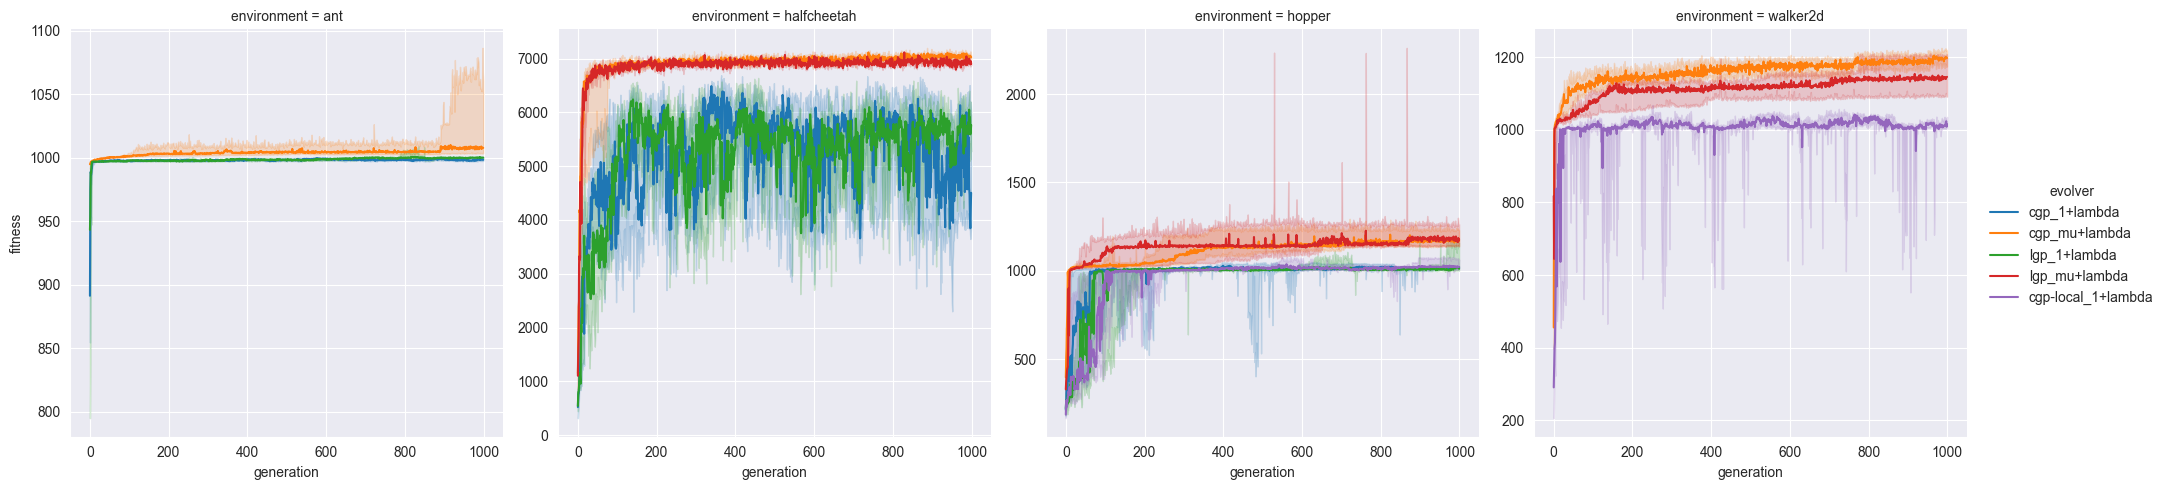

In [33]:
g = sns.relplot(
    data=df[(df["generation"] < 1000)],
    col="environment",
    kind="line",
    x="generation",
    y="top_k_fit.top_0_fit",
    hue="evolver",
    estimator="median",
    errorbar=("pi", 50),
    facet_kws=dict(sharey=False)
)
g.set_xlabels("generation")
g.set_ylabels("fitness")
plt.show()

In [34]:
graph_dfs = [pd.read_csv(f"data/graph_size/{d}") for d in os.listdir("data/graph_size/")]
graph_sizes = pd.concat(graph_dfs, ignore_index=True)
graph_sizes["relative_size"] = graph_sizes["graph_size"] / graph_sizes["max_size"]
graph_sizes["evolver"] = graph_sizes["solver"] + "_" + graph_sizes["ea"]
graph_sizes = graph_sizes[[c for c in graph_sizes.columns if not c.startswith("Unnamed")]]
graph_sizes.head()

,seed,generation,graph_size,max_size,solver,ea,environment,relative_size,evolver
0,1,799,88,137,cgp,1+lambda,ant,0.642336,cgp_1+lambda
1,5,1699,87,137,cgp,1+lambda,ant,0.635036,cgp_1+lambda
2,7,3999,90,137,cgp,1+lambda,ant,0.656934,cgp_1+lambda
3,6,4399,89,137,cgp,1+lambda,ant,0.649635,cgp_1+lambda
4,3,3199,90,137,cgp,1+lambda,ant,0.656934,cgp_1+lambda


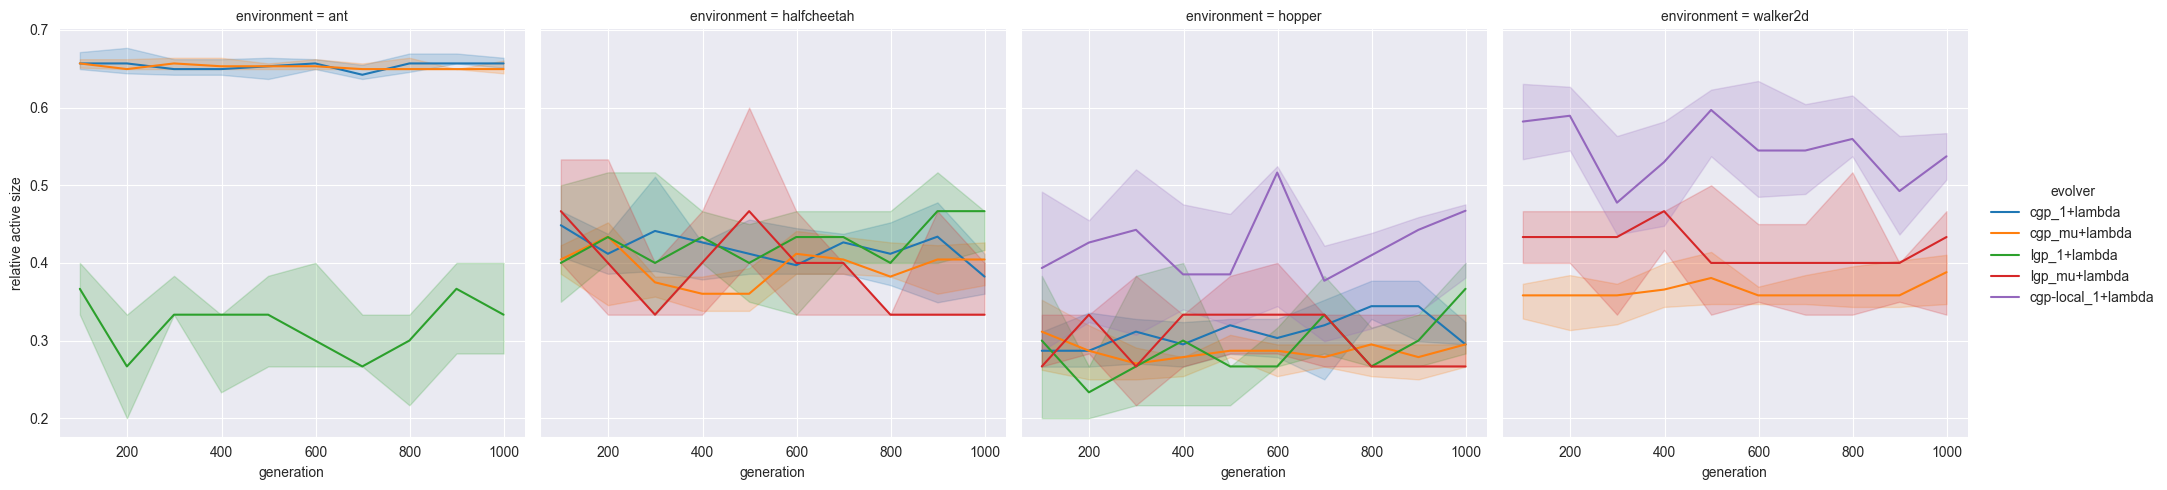

In [38]:
g = sns.relplot(
    data=graph_sizes[(graph_sizes["generation"] < 1000)],
    col="environment",
    kind="line",
    x="generation",
    y="relative_size",
    hue="evolver",
    estimator="median",
    errorbar=("pi", 50)
)
g.set_xlabels("generation")
g.set_ylabels("relative active size")
plt.show()

In [36]:
join_df = graph_sizes.merge(df, on=["solver", "generation", "environment", "seed", "evolver", "ea"])
# max_gens = join_df.groupby(["solver", "environment", "seed"])["generation"].max().reset_index()
# join_df = join_df.merge(max_gens, on=["solver", "generation", "environment", "seed"])
join_df = join_df[join_df["generation"] == 999]
join_df.head()

,seed,generation,graph_size,max_size,solver,ea,environment,relative_size,evolver,_timestamp,...,fitness_median,top_k_fit.top_0_fit,top_k_fit.top_1_fit,fitness_mean,evaluation_time,_step,_runtime,run_id,fitness_1q,fitness_3q
56,8,999,91,137,cgp,1+lambda,ant,0.664234,cgp_1+lambda,1.686363e+09,...,876.631592,999.863098,973.189880,805.838135,4.755998,9998,4921.931694,8,952.467102,665.918701
206,5,999,91,137,cgp,1+lambda,ant,0.664234,cgp_1+lambda,1.686363e+09,...,990.064087,999.837036,999.836365,880.350403,4.755998,9995,4921.886831,5,999.671936,765.120605
246,4,999,90,137,cgp,1+lambda,ant,0.656934,cgp_1+lambda,1.686363e+09,...,932.854736,997.953735,997.663757,857.408142,4.755998,9994,4921.871499,4,997.250610,700.878113
316,7,999,92,137,cgp,1+lambda,ant,0.671533,cgp_1+lambda,1.686363e+09,...,976.176025,998.383057,997.808655,873.356079,4.755998,9997,4921.917124,7,996.696167,764.372070
369,9,999,90,137,cgp,1+lambda,ant,0.656934,cgp_1+lambda,1.686363e+09,...,704.336792,996.885498,996.152527,748.074768,4.755998,9999,4921.947128,9,890.935913,665.105469


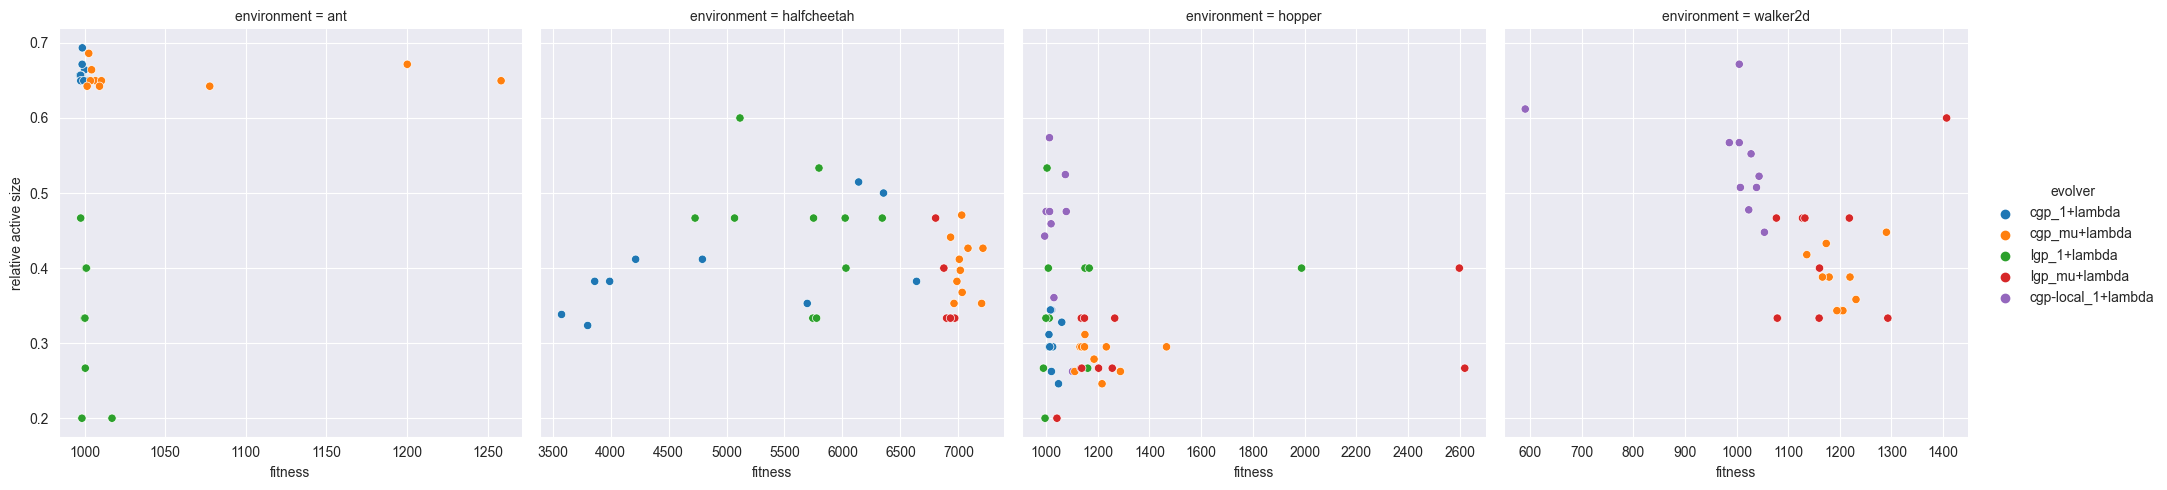

In [39]:
g = sns.relplot(
    data=join_df,
    col="environment",
    kind="scatter",
    x="top_k_fit.top_0_fit",
    y="relative_size",
    hue="evolver",
    facet_kws=dict(sharex=False)
)
g.set_xlabels("fitness")
g.set_ylabels("relative active size")
plt.show()